In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import random
from collections import Counter
import sys
%matplotlib inline

# Our City

These are constants that define the behaviour of the city - 

In [124]:
CITY_POPULATION = 10000
MEAN_NETWORK_DEGREE = 50
MEAN_INTERACTIONS_PER_DAY = 20
TOTAL_INITIAL_INFECTIONS = 10

The city is modeled as a small-world network graph (https://en.wikipedia.org/wiki/Small-world_network)

The graph is generated using the Watts–Strogatz model (https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model)

In [100]:
BETA = 0.5 # a parameter for the Watts–Strogatz read wiki page for more details
city_social_network = nx.watts_strogatz_graph(CITY_POPULATION, MEAN_NETWORK_DEGREE, BETA)


### Network characteristics

Let's look at the distribution of number of connections each person has in the city

<BarContainer object of 32 artists>

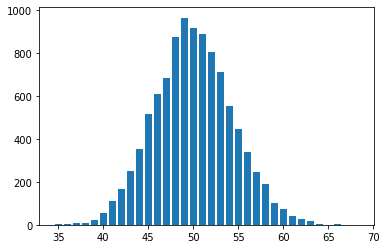

In [101]:
degrees = dict(city_social_network.degree()).values()
degree_counts = np.unique(list(degrees), return_counts = True)
degree_counts
plt.bar(degree_counts[0], degree_counts[1]) 


Age is an important characteristic in the prognosis of many diseases, including COVID'19

We model our city's population's age on that of the USA.
Based on 2000 Census data (https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf)

In [102]:
age_group_numbers_USA = [19175798,20549505,20528072,20219890,18964001,19381336,20510388,22706664,22441863, 20092404,17585548,13469237, 10805447,9533545,8857441,7415813,4945367,2789818,1112531,286784,50454,]

Each age group is of 5 years - under 5yo, 5-10, 10-15 .... 95-100, >100

For convenience, we choose a representative age for each group

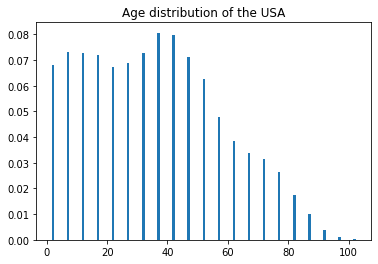

In [103]:
age_group_ratios = np.array(age_group_numbers_USA)/sum(age_group_numbers_USA)
ages = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102]
plt.bar(ages, age_group_ratios)
plt.title('Age distribution of the USA')
plt.show()

Assigning an age to each person in our city

In [104]:
city_ages = np.random.choice(ages, CITY_POPULATION, p = age_group_ratios)

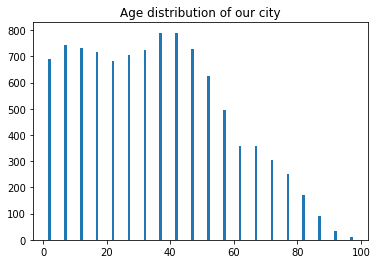

In [105]:
age_dist = np.unique(city_ages, return_counts = True)
plt.bar(age_dist[0], age_dist[1])
plt.title('Age distribution of our city')
plt.show()

Wrapping all of this into a single function for convenience, and initializing some other parameters 

In [125]:
def init_city():
    city_social_network = nx.watts_strogatz_graph(CITY_POPULATION, MEAN_NETWORK_DEGREE, BETA)
    city_ages = np.random.choice(ages, CITY_POPULATION, p = age_group_ratios)
    for i in range(CITY_POPULATION):
        city_social_network.nodes[i]['age'] = city_ages[i]
        city_social_network.nodes[i]['infected'] = False
        city_social_network.nodes[i]['alive'] = True
        city_social_network.nodes[i]['isolated'] = False
        city_social_network.nodes[i]['infected_date'] = sys.maxsize
        city_social_network.nodes[i]['recovered'] = False
        city_social_network.nodes[i]['symptomatic'] = False
        
    return city_social_network


# Our disease
Some parameters that define our disease

In [107]:
TRANSMISSION_RATE = 1.0/100
ILLNESS_LENGTH_DAYS = 14
SYMPTOMATIC_RATE = 0.5
DAYS_UNTIL_SYMPTOMS_SHOWN = 7

We define a probabilty function of the disease being fatal - based on the age of the patient

In [108]:
def mortality_pdf(age):
    # a slightly simplistic placeholder 
    return ((age-102)/1020 +0.2)

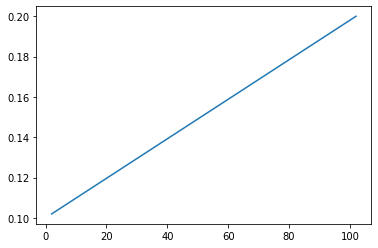

In [109]:
plt.plot(ages,[mortality_pdf(age) for age in ages])

# Now, the actual simulations

In [110]:
def get_disease_stats(city_graph):
    """
    Look at the disease spread in the population
    """
    total_infected = 0
    total_dead = 0
    total_healthy = 0
    total_recovered = 0
    for i in city_graph.nodes():
        if not city_graph.nodes[i]['alive']:
            total_dead+=1
        #dead people are not infected
        elif city_graph.nodes[i]['infected']:
            total_infected +=1
        elif city_graph.nodes[i]['recovered']:
            total_recovered +=1
        
        else:
            total_healthy+=1
    return{'infected':total_infected, 'dead': total_dead, 'never infected':total_healthy, 'recovered': total_recovered}
        
        

Based on the previously defined behaviour of our citizens, we generate a set of 'interactions' for the day. An interaction is a meeting between two people that may spread the disease

The below function assumes no preventative measures are made at all

In [111]:
def get_daily_visits_no_preventative_measures(city_graph):
    total_visits_in_day = (len(city_graph.nodes)*MEAN_INTERACTIONS_PER_DAY)/2 # Two people take part in an interaction
    day_visits = random.sample(list(city_graph.edges), int(total_visits_in_day))
    return day_visits
    

Distribution of Interactions on Day 0 (by person):

In [112]:
day_0_interactions = get_daily_visits_no_preventative_measures(city_social_network)
interactions_per_person = Counter()
for interaction in day_0_interactions:
    interactions_per_person[interaction[0]]+=1
    interactions_per_person[interaction[1]]+=1
    

<BarContainer object of 28 artists>

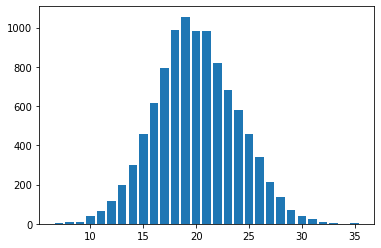

In [113]:
hist = np.unique(list(interactions_per_person.values()), return_counts = True)
plt.bar(hist[0],hist[1])

In [114]:

def simulate_single_day(city_graph, day_number, daily_visit_method, *daily_visit_method_special_args):
    
    if daily_visit_method_special_args:
        interactions = daily_visit_method(city_graph, daily_visit_method_special_args)
    else:
        interactions = daily_visit_method(city_graph)
    for p1,p2 in interactions:
        if not city_graph.nodes[p1]['alive'] or not city_graph.nodes[p2]['alive']:
            continue
        if city_graph.nodes[p1]['infected'] and city_graph.nodes[p2]['infected']:
            continue
        if city_graph.nodes[p1]['recovered'] or city_graph.nodes[p2]['recovered']:
            continue
        if not city_graph.nodes[p1]['infected'] and not city_graph.nodes[p2]['infected']:
            continue
        # one of the people is infected.
        if random.uniform(0, 1) < TRANSMISSION_RATE:
            #infect!
            if not city_graph.nodes[p1]['infected']:
                
                city_graph.nodes[p1]['infected'] = True
                city_graph.nodes[p1]['infected_date'] = day_number
                
            else:
                
                city_graph.nodes[p2]['infected'] = True
                city_graph.nodes[p2]['infected_date'] = day_number
                
    for p in city_graph.nodes():
        if day_number - city_graph.nodes[p]['infected_date'] == ILLNESS_LENGTH_DAYS:
            if city_graph.nodes[p]['symptomatic']:
                if random.uniform(0, 1) < mortality_pdf(city_graph.nodes[p]['age'])/SYMPTOMATIC_RATE :
                    city_graph.nodes[p]['alive'] = False
                    continue
       
            city_graph.nodes[p]['recovered'] = True
            city_graph.nodes[p]['infected'] = False
        if day_number - city_graph.nodes[p]['infected_date'] == DAYS_UNTIL_SYMPTOMS_SHOWN:
            if random.uniform(0,1) < SYMPTOMATIC_RATE:
                city_graph.nodes[p]['symptomatic'] = True
                
                
  

In [126]:
def simulate_disease_spread(daily_visit_method, *daily_visit_method_special_args):
    city_social_network = init_city()
    daily_stats = []
    initial_infections = random.sample(range(0, CITY_POPULATION), TOTAL_INITIAL_INFECTIONS)
    for i in initial_infections:
        city_social_network.nodes[i]['infected'] = True
        city_social_network.nodes[i]['infected_date'] = 0
    total_infections = TOTAL_INITIAL_INFECTIONS
    day=0
    while total_infections>0:
        #TODO ugly
        if daily_visit_method_special_args:
            simulate_single_day(city_social_network,day, daily_visit_method, daily_visit_method_special_args)
        else:
            simulate_single_day(city_social_network,day, daily_visit_method)
        daily_stats.append(get_disease_stats(city_social_network))
        
        total_infections = daily_stats[-1]['infected']
        day+=1
    return daily_stats


In [127]:
def display_infection_progression(daily_stats):
    df = pd.DataFrame(daily_stats)
    colors = [[0.5,0.5,0.5], [0.6,0,0], [0,0.5,0],[0,0.75,0] ] # grey, red, light green, dark green
    ax = df.plot(y = ['dead', 'infected', 'recovered', 'never infected'], color = colors)
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of people')
    plt.show()
    
    ax = df.plot.area(y = ['dead', 'infected', 'recovered', 'never infected'], color = colors)
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of people')
    plt.show()
    print(daily_stats[-1])
  

    

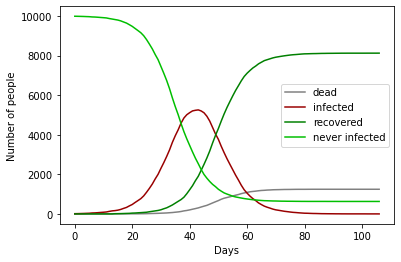

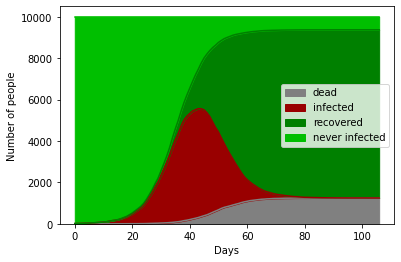

{'infected': 0, 'dead': 1246, 'never infected': 630, 'recovered': 8124}


In [128]:
daily_stats_no_preventative = simulate_disease_spread(get_daily_visits_no_preventative_measures)
display_infection_progression(daily_stats_no_preventative)

## Prevention method 1

People who develop symptoms either stay at home/wear effective protective gear/ prevent themselves from spreading the disease in some other way.

Symptoms are developed by random chance, based on SYMPTOMATIC_RATE



In [129]:
def get_daily_visits_stay_at_home_symptomatic(city_graph):
    total_visits_in_day = (len(city_graph.nodes)*MEAN_INTERACTIONS_PER_DAY)/2 # Two people take part in an interaction
    day_visits = random.sample(list(city_graph.edges), int(total_visits_in_day))
    filtered_visits = []
    for p1,p2 in day_visits:
        if city_graph.nodes[p1]['symptomatic'] or city_graph.nodes[p2]['symptomatic']:
            continue
        filtered_visits.append((p1,p2))
    
    return filtered_visits

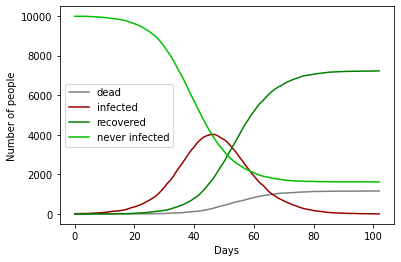

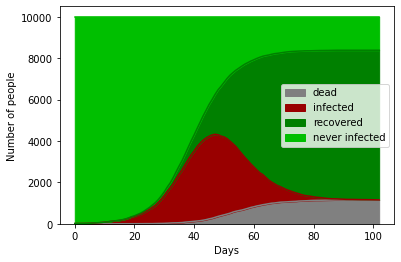

{'infected': 0, 'dead': 1156, 'never infected': 1619, 'recovered': 7225}


In [130]:
daily_stats_stay_home = simulate_disease_spread(get_daily_visits_stay_at_home_symptomatic)
display_infection_progression(daily_stats_stay_home)

## Prevention method 2

Social isolation - the average number of interactions per person per day is reduced to a fraction of (_x_ * MEAN_INTERACTIONS_PER_DAY),  0<_x_<1

In [131]:
def get_daily_visits_social_isolation(city_graph, reduction_fraction):
    reduction_fraction = reduction_fraction[0][0]
    total_visits_in_day = (len(city_graph.nodes)*MEAN_INTERACTIONS_PER_DAY)*reduction_fraction/2 # Two people take part in an interaction
    day_visits = random.sample(list(city_graph.edges), int(total_visits_in_day))
    return day_visits

Reduction fraction = 1.0


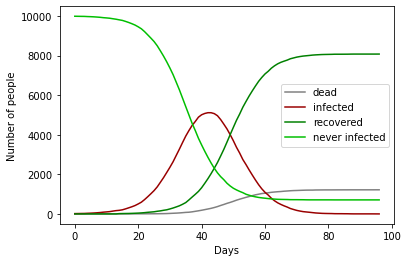

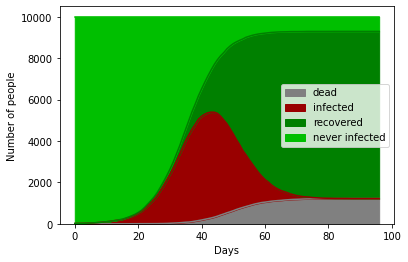

{'infected': 0, 'dead': 1218, 'never infected': 708, 'recovered': 8074}




Reduction fraction = 0.9


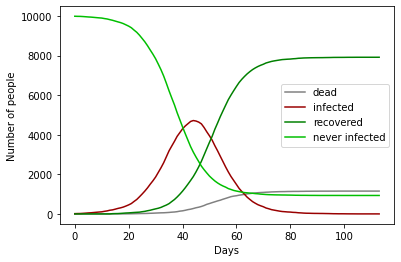

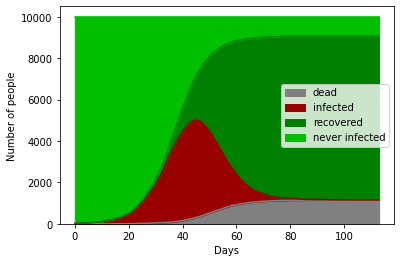

{'infected': 0, 'dead': 1153, 'never infected': 932, 'recovered': 7915}




Reduction fraction = 0.8


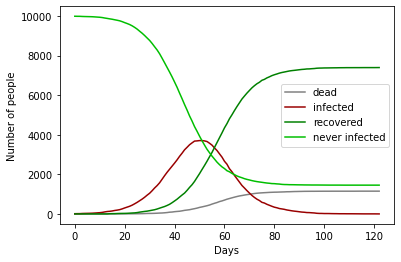

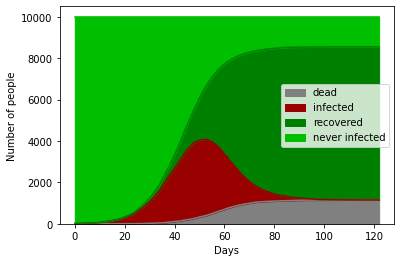

{'infected': 0, 'dead': 1150, 'never infected': 1454, 'recovered': 7396}




Reduction fraction = 0.7


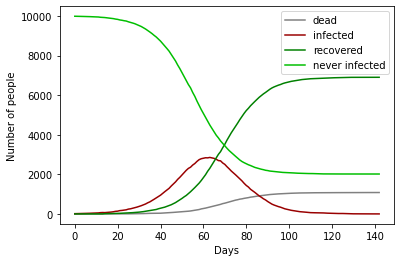

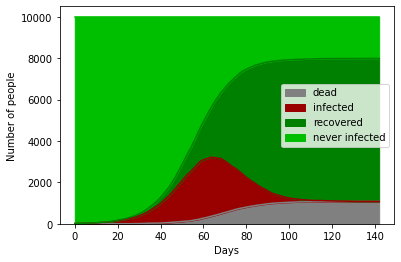

{'infected': 0, 'dead': 1081, 'never infected': 2016, 'recovered': 6903}




Reduction fraction = 0.6


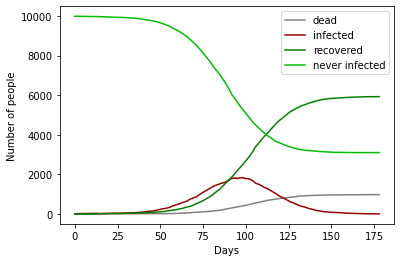

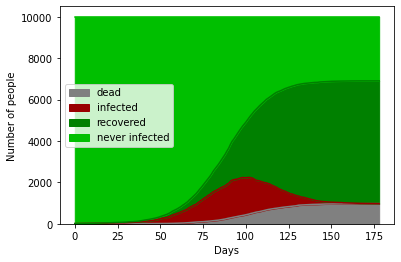

{'infected': 0, 'dead': 976, 'never infected': 3098, 'recovered': 5926}




Reduction fraction = 0.5


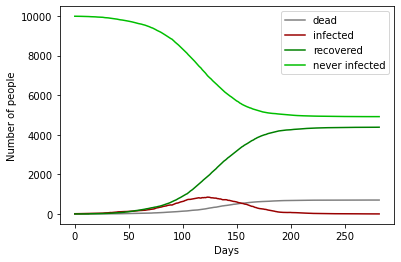

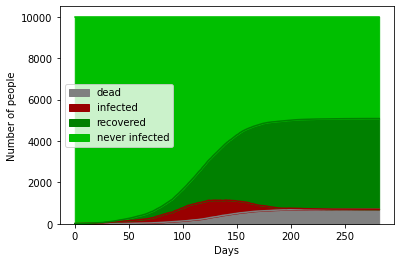

{'infected': 0, 'dead': 701, 'never infected': 4917, 'recovered': 4382}




Reduction fraction = 0.4


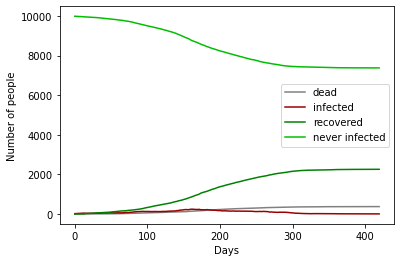

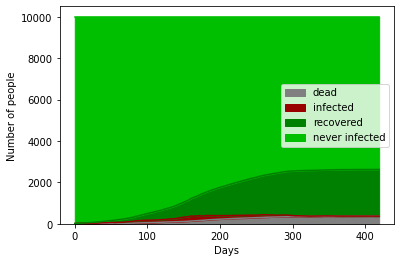

{'infected': 0, 'dead': 370, 'never infected': 7376, 'recovered': 2254}




Reduction fraction = 0.3


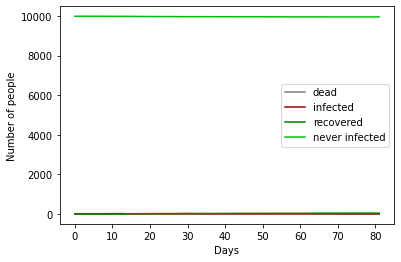

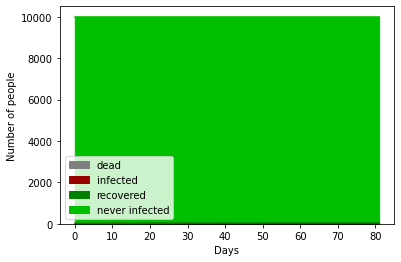

{'infected': 0, 'dead': 3, 'never infected': 9957, 'recovered': 40}




Reduction fraction = 0.2


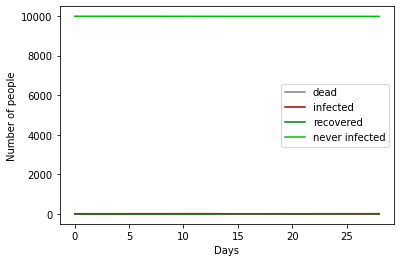

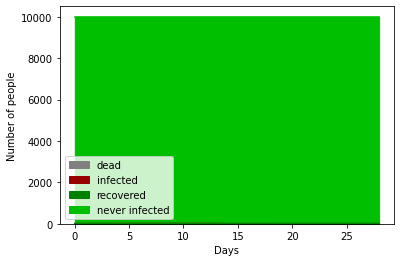

{'infected': 0, 'dead': 1, 'never infected': 9985, 'recovered': 14}




Reduction fraction = 0.1


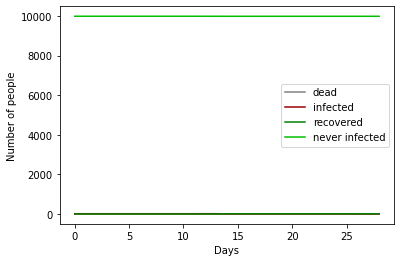

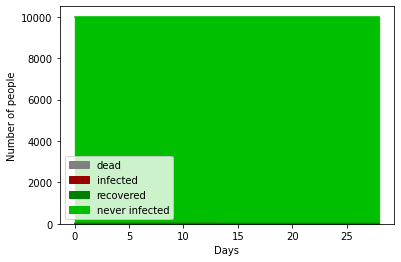

{'infected': 0, 'dead': 3, 'never infected': 9988, 'recovered': 9}






In [135]:
all_runs_data = []
for i in range(10,0,-1):
    reduction_fraction = i/10
    print('Reduction fraction = {}'.format(reduction_fraction))
    daily_stats_isolation = simulate_disease_spread(get_daily_visits_social_isolation, reduction_fraction)
    display_infection_progression(daily_stats_isolation)
    all_runs_data.append(daily_stats_isolation)
    print('\n\n\n')
    